In [54]:
print('''
Problem Statement: In our previous example , our data is limited in scope with only 2 timestamps. When we deal with panel data, 
we deal with data with entities (cities, people, units, etc) that span over time. 

Goal: As we aim to do analyses on this panel data, we have coviarates that can bias our results that are invariant over time. Meaning they don't change (ethnicity, race, geographic data), etc. 
In addition, we have data that might be specific to the entities (cities, people, units) so we want to have data thats specific for these entities and also accounting for these time invariant factors. 

Hence leads us to use the technique of Regression with Fixed Effects. This notebook aims to explore this
''')


Problem Statement: In our previous example , our data is limited in scope with only 2 timestamps. When we deal with panel data, 
we deal with data with entities (cities, people, units, etc) that span over time. 

Goal: As we aim to do analyses on this panel data, we have coviarates that can bias our results that are invariant over time. Meaning they don't change (ethnicity, race, geographic data), etc. 
In addition, we have data that might be specific to the entities (cities, people, units) so we want to have data thats specific for these entities and also accounting for these time invariant factors. 

Hence leads us to use the technique of Regression with Fixed Effects. This notebook aims to explore this



In [55]:
#Loading income data. Goal: Does being married have an impact on age
data = wage_panel.load()
data.head()

,nr,year,black,exper,hisp,hours,married,educ,union,lwage,expersq,occupation
0,13,1980,0,1,0,2672,0,14,0,1.197540,1,9
1,13,1981,0,2,0,2320,0,14,1,1.853060,4,9
2,13,1982,0,3,0,2940,0,14,0,1.344462,9,9
3,13,1983,0,4,0,2960,0,14,0,1.433213,16,9
4,13,1984,0,5,0,3071,0,14,0,1.568125,25,5


In [56]:
#Creating a model of dummy variable(year) on wage
mod = smf.ols("lwage ~ C(year)", data=data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.3935,0.022,63.462,0.000,1.350,1.437
C(year)[T.1981],0.1194,0.031,3.845,0.000,0.059,0.180
C(year)[T.1982],0.1782,0.031,5.738,0.000,0.117,0.239
C(year)[T.1983],0.2258,0.031,7.271,0.000,0.165,0.287
C(year)[T.1984],0.2968,0.031,9.558,0.000,0.236,0.358
C(year)[T.1985],0.3459,0.031,11.140,0.000,0.285,0.407
C(year)[T.1986],0.4062,0.031,13.082,0.000,0.345,0.467
C(year)[T.1987],0.4730,0.031,15.232,0.000,0.412,0.534


In [57]:
#Key Insight: BY doing on a dummy avariable, we are predicting based off the mean of that variable
data.groupby("year")["lwage"].mean()


year
1980    1.393477
1981    1.512867
1982    1.571667
1983    1.619263
1984    1.690295
1985    1.739410
1986    1.799719
1987    1.866479
Name: lwage, dtype: float64

In [58]:
#IF we extend this logic, we do a demeaned time strategey, substract the mean from X&Y then apply regression, 

#Since time invariant is fixed, we substract out all the effects


![Alt text](https://i.imgur.com/5gf5skP.png)


In [62]:
#Whats our time invariant variables? 
data.groupby("nr").std().sum()


year            1334.971910
black              0.000000
exper           1334.971910
hisp               0.000000
hours         203098.215649
married          140.372801
educ               0.000000
union            106.512445
lwage            173.929670
expersq        17608.242825
occupation       739.222281
dtype: float64

In [63]:
data.head()

,nr,year,black,exper,hisp,hours,married,educ,union,lwage,expersq,occupation
0,13,1980,0,1,0,2672,0,14,0,1.197540,1,9
1,13,1981,0,2,0,2320,0,14,1,1.853060,4,9
2,13,1982,0,3,0,2940,0,14,0,1.344462,9,9
3,13,1983,0,4,0,2960,0,14,0,1.433213,16,9
4,13,1984,0,5,0,3071,0,14,0,1.568125,25,5


In [64]:
Y = "lwage"
T = "married"
X = [T, "expersq", "union", "hours"]

mean_data = data.groupby("nr")[X+[Y]].mean()
mean_data.head()

,married,expersq,union,hours,lwage
nr,,,,,
13,0.000,25.5,0.125,2807.625,1.255652
17,0.000,61.5,0.000,2504.125,1.637786
18,1.000,61.5,0.000,2350.500,2.034387
45,0.125,35.5,0.250,2225.875,1.773664
110,0.500,77.5,0.125,2108.000,2.055129


In [69]:
#De mean the data PER entity
demeaned_data = (data
               .set_index("nr") # set the index as the person indicator
               [X+[Y]]
               - mean_data) # subtract the mean data

demeaned_data.head()

,married,expersq,union,hours,lwage
nr,,,,,
13,0.0,-24.5,-0.125,-135.625,-0.058112
13,0.0,-21.5,0.875,-487.625,0.597408
13,0.0,-16.5,-0.125,132.375,0.088810
13,0.0,-9.5,-0.125,152.375,0.177561
13,0.0,-0.5,-0.125,263.375,0.312473


In [73]:
#Can finally regress. Impact we see is ~11.48% #Accounts for time, bigger standard error
mod = smf.ols(f"{Y} ~ {'+'.join(X)}", data=demeaned_data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-1.874e-16,0.005,-3.69e-14,1.000,-0.010,0.010
married,0.1147,0.017,6.756,0.000,0.081,0.148
expersq,0.0040,0.000,21.958,0.000,0.004,0.004
union,0.0784,0.018,4.261,0.000,0.042,0.115
hours,-8.46e-05,1.25e-05,-6.744,0.000,-0.000,-6e-05


In [75]:
from linearmodels.panel import PanelOLS #does not account for time strcuture), bigger standrad error
mod = PanelOLS.from_formula("lwage ~ expersq+union+married+hours+EntityEffects",
                            data=data.set_index(["nr", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True)
result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
expersq,0.0040,0.0002,16.552,0.0000,0.0035,0.0044
union,0.0784,0.0236,3.3225,0.0009,0.0322,0.1247
married,0.1147,0.0220,5.2213,0.0000,0.0716,0.1577
hours,-8.46e-05,2.22e-05,-3.8105,0.0001,-0.0001,-4.107e-05


In [76]:
mod = smf.ols("lwage ~ expersq+union+married+hours+black+hisp+educ", data=data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2654,0.065,4.103,0.000,0.139,0.392
expersq,0.0032,0.000,15.750,0.000,0.003,0.004
union,0.1829,0.017,10.598,0.000,0.149,0.217
married,0.1410,0.016,8.931,0.000,0.110,0.172
hours,-5.32e-05,1.34e-05,-3.978,0.000,-7.94e-05,-2.7e-05
black,-0.1347,0.024,-5.679,0.000,-0.181,-0.088
hisp,0.0132,0.021,0.632,0.528,-0.028,0.054
educ,0.1057,0.005,22.550,0.000,0.097,0.115


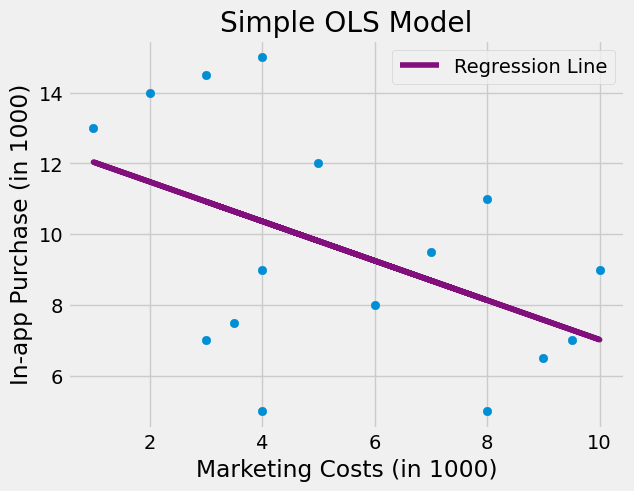

In [78]:
#Let's look at another example. Whats the effect of marking on purchases ? 

toy_panel = pd.DataFrame({
    "mkt_costs":[5,4,3.5,3, 10,9.5,9,8, 4,3,2,1, 8,7,6,4],
    "purchase":[12,9,7.5,7, 9,7,6.5,5, 15,14.5,14,13, 11,9.5,8,5],
    "city":["C0","C0","C0","C0", "C2","C2","C2","C2", "C1","C1","C1","C1", "C3","C3","C3","C3"]
})

m = smf.ols("purchase ~ mkt_costs", data=toy_panel).fit()

plt.scatter(toy_panel.mkt_costs, toy_panel.purchase)
plt.plot(toy_panel.mkt_costs, m.fittedvalues, c="C5", label="Regression Line")
plt.xlabel("Marketing Costs (in 1000)")
plt.ylabel("In-app Purchase (in 1000)")
plt.title("Simple OLS Model")
plt.legend();

In [79]:
print('''The cocnlsion is more marketing, less purhcases, which seems opposite of we expect? BUt with multiple cities , we need to account for this 
This is again, per "entity", hence fixed effects needed
    ''')

The cocnlsion is more marketing, less purhcases, which seems opposite of we expect? BUt with multiple cities , we need to account for this 
This is again, per "entity", hence fixed effects needed
    


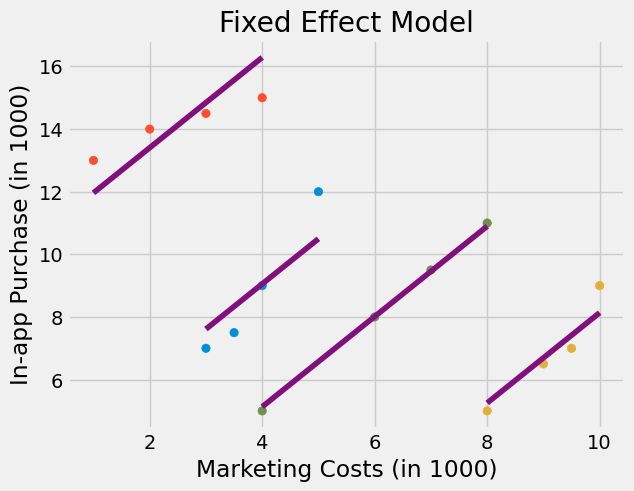

In [80]:
fe = smf.ols("purchase ~ mkt_costs + C(city)", data=toy_panel).fit()

fe_toy = toy_panel.assign(y_hat = fe.fittedvalues)

plt.scatter(toy_panel.mkt_costs, toy_panel.purchase, c=toy_panel.city)
for city in fe_toy["city"].unique():
    plot_df = fe_toy.query(f"city=='{city}'")
    plt.plot(plot_df.mkt_costs, plot_df.y_hat, c="C5")

plt.title("Fixed Effect Model")
plt.xlabel("Marketing Costs (in 1000)")
plt.ylabel("In-app Purchase (in 1000)");

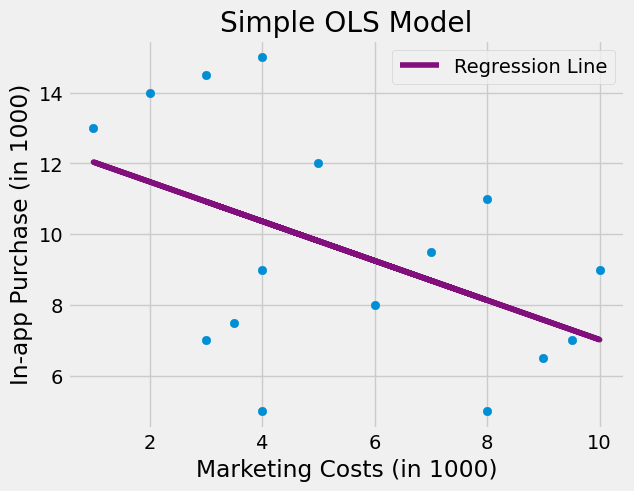

In [25]:
print('''So we accounted for the entity, how do we account for time? reverting back to our marriage example, we can extend this model''')

In [82]:
mod = PanelOLS.from_formula("lwage ~ expersq+union+married+hours+EntityEffects+TimeEffects",
                            data=data.set_index(["nr", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
result.summary.tables[1]
#Marriage effect now only 4.76%

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
expersq,-0.0062,0.0008,-8.1479,0.0000,-0.0077,-0.0047
union,0.0727,0.0228,3.1858,0.0015,0.0279,0.1174
married,0.0476,0.0177,2.6906,0.0072,0.0129,0.0823
hours,-0.0001,3.546e-05,-3.8258,0.0001,-0.0002,-6.614e-05


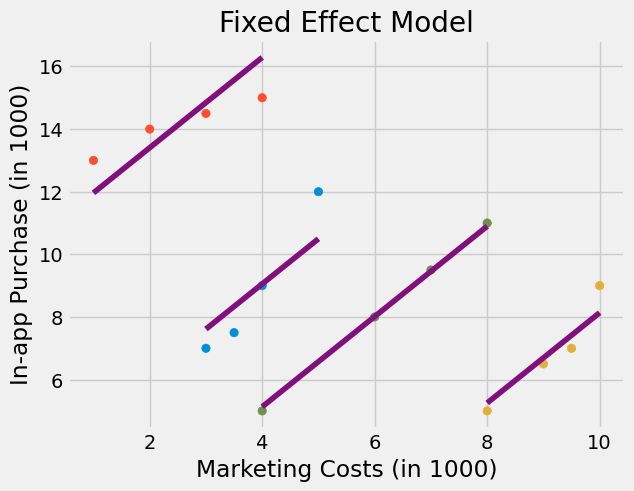

In [28]:
fe = smf.ols("purchase ~ mkt_costs + C(city)", data=toy_panel).fit()

fe_toy = toy_panel.assign(y_hat = fe.fittedvalues)

plt.scatter(toy_panel.mkt_costs, toy_panel.purchase, c=toy_panel.city)
for city in fe_toy["city"].unique():
    plot_df = fe_toy.query(f"city=='{city}'")
    plt.plot(plot_df.mkt_costs, plot_df.y_hat, c="C5")

plt.title("Fixed Effect Model")
plt.xlabel("Marketing Costs (in 1000)")
plt.ylabel("In-app Purchase (in 1000)");

In [32]:
#When is panel data useful? When you dont have random data. OR data that is chnaging in time. 

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
expersq,-0.0062,0.0008,-8.1479,0.0000,-0.0077,-0.0047
union,0.0727,0.0228,3.1858,0.0015,0.0279,0.1174
married,0.0476,0.0177,2.6906,0.0072,0.0129,0.0823
hours,-0.0001,3.546e-05,-3.8258,0.0001,-0.0002,-6.614e-05


In [59]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr
from linearmodels.datasets import wage_panel
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
style.use("fivethirtyeight")
pd.reset_option('display.max_columns')
from linearmodels.datasets import wage_panel
